In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()
df.shape

(1460, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:

df[df.select_dtypes(['int64', 'float']).columns].shape

(1460, 38)

In [6]:
df.isna().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

<AxesSubplot:>

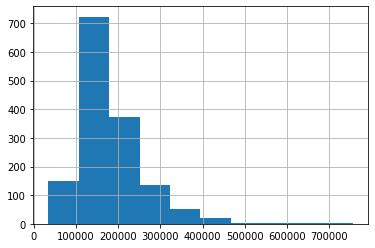

In [7]:
df.saleprice.hist()

In [8]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [16]:
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
X['garage_interaction']=X['garagecars']*X['garagearea']
X=X.drop(columns=['mszoning_FV', 'mszoning_RL', 'garagearea', 'garagecars'])
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 94)

In [17]:
lm=LinearRegression().fit(X_train, y_train)
y_preds_train = lm.predict(X_train)
y_preds_test = lm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.7606261129528502
-----Test set statistics-----
R-squared of the model in the test set is: 0.8352217399904829
Mean absolute error of the prediction is: 23062.09593002256
Mean squared error of the prediction is: 1045116067.713843
Root mean squared error of the prediction is: 32328.25494383888
Mean absolute percentage error of the prediction is: 14.47621339596992


In [18]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [19]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)
print(f"selected alpha: {ridge_cv.alpha_}")

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("R-squared of the model in the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

selected alpha: 10.0
R-squared of the model in the training set is: 0.7602773165180403
-----Test set statistics-----
R-squared of the model in the test set is: 0.8357042005901122
Mean absolute error of the prediction is: 23008.877217318743
Mean squared error of the prediction is: 1042056032.2171553
Root mean squared error of the prediction is: 32280.89267999191
Mean absolute percentage error of the prediction is: 14.523783671514115


In [20]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)
print(f"selected alpha: {lasso_cv.alpha_}")

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

selected alpha: 10.0
R-squared of the model in the training set is: 0.760618219001313
-----Test set statistics-----
R-squared of the model in the test set is: 0.835456935185654
Mean absolute error of the prediction is: 23052.83851964682
Mean squared error of the prediction is: 1043624327.9812572
Root mean squared error of the prediction is: 32305.174941195677
Mean absolute percentage error of the prediction is: 14.485593064058644


In [21]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train,y_train)

print(f"selected alpha: {elasticnet_cv.alpha_}")
print(f"selected l1_ratio: {elasticnet_cv.l1_ratio_}")

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("R-squared of the model in the training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

selected alpha: 0.01
selected l1_ratio: 0.5
R-squared of the model in the training set is: 0.760400363512068
-----Test set statistics-----
R-squared of the model in the test set is: 0.8358308606642333
Mean absolute error of the prediction is: 23009.82509830985
Mean squared error of the prediction is: 1041252683.0460078
Root mean squared error of the prediction is: 32268.447174383953
Mean absolute percentage error of the prediction is: 14.517349567633417


The OLS model gives the best R^2 value and 